In [1]:
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_features = pd.read_csv('data/train_features.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')

test_features = pd.read_csv('data/test_features.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [6]:
train_targets_scored.sum()[1:].sort_values()

atp-sensitive_potassium_channel_antagonist      1
erbb2_inhibitor                                 1
diuretic                                        6
autotaxin_inhibitor                             6
protein_phosphatase_inhibitor                   6
                                             ... 
serotonin_receptor_antagonist                 404
dopamine_receptor_antagonist                  424
cyclooxygenase_inhibitor                      435
proteasome_inhibitor                          726
nfkb_inhibitor                                832
Length: 206, dtype: object

In [7]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

(27796, 772)


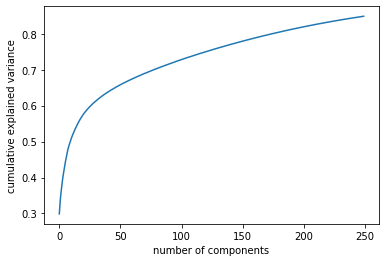

In [8]:
n_comp = 250

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
print(data.shape)
pca = (PCA(n_components=n_comp, random_state=42).fit(data[GENES]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [9]:
%%time
# GENES
n_comp = 100

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

CPU times: user 11.7 s, sys: 10 s, total: 21.7 s
Wall time: 1.98 s


(27796, 100)


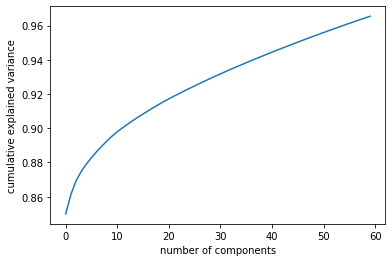

In [10]:
n_comp = 60

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
print(data.shape)
pca = (PCA(n_components=n_comp, random_state=42).fit(data[CELLS]))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [11]:
%%time
#CELLS
n_comp = 15

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

CPU times: user 792 ms, sys: 1.35 s, total: 2.14 s
Wall time: 180 ms


In [12]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(threshold=0.5)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features


,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,967,968,969,970,971,972,973,974,975,976
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-0.450285,-0.176778,-1.262943,0.219107,-0.890670,0.393604,-0.703376,-0.615139,0.174407,0.082941
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.063234,0.658824,0.429385,-0.226422,0.271831,0.863835,0.003597,0.669397,0.447651,1.207365
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.115802,0.726273,-0.212644,-0.902482,-0.118799,-0.336548,0.015536,0.572233,-0.261651,-0.638141
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.590366,0.698760,0.050321,-0.793301,0.295411,0.147857,0.056161,0.689218,-1.433683,1.323147
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,-0.000223,-0.287454,-0.110246,-0.105291,-0.396913,0.090983,-0.211590,0.350304,-0.326626,-0.344389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,-0.492270,0.802396,0.332499,-0.204876,0.238577,-0.483204,0.585078,0.173586,-0.611718,1.607084
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,-1.364079,-0.375444,-1.433534,-0.858483,1.072457,0.101450,0.435098,-0.219500,0.377156,0.555680
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,-0.511130,-0.035609,-0.310135,-0.166686,-0.458886,-0.003948,0.292592,0.331622,-0.006669,0.081750
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-1.129357,0.020524,-0.043233,-0.440007,0.302835,0.776086,-1.737516,-0.531532,-0.351892,0.542268


In [13]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [14]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [15]:
train

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Binning

# for col in GENES:
#     train.loc[:, f'{col}_bin'] = pd.cut(train[col], bins=3, labels=False)
#     test.loc[:, f'{col}_bin'] = pd.cut(test[col], bins=3, labels=False)

In [17]:
# Distribution plots

# plt.figure(figsize=(16,16))
# sns.set_style("whitegrid")

# gene_choice = np.random.choice(len(GENES), 16)
# for i, col in enumerate(gene_choice):
#     plt.subplot(4, 4, i+1)
#     plt.hist(train_features.loc[:, GENES[col]],bins=100, color='orange')
#     plt.title(GENES[col])

In [18]:
# train_ = train.copy() [Didn't wanted to actually normalize, so created a copy and normalized that for further calculation]
# for col in GENES:
    
# #     train_[col] = (train[col]-np.mean(train[col])) / (np.std(train[col]))
    
#     mean = train_[col].mean()
#     std = train_[col].std()

#     std_r = mean + 4*std
#     std_l = mean - 4*std

#     drop = train_[col][(train_[col]>std_r) | (train_[col]<std_l)].index.values

# train = train.drop(drop).reset_index(drop=True)
# # folds = folds.drop(drop).reset_index(drop=True)
# target = target.drop(drop).reset_index(drop=True)

In [19]:
# n_comp = 50

# data = pd.concat([pd.DataFrame(train[CELLS]), pd.DataFrame(test[CELLS])])
# data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
# train2 = data2[:train.shape[0]]; test2 = data2[train.shape[0]:]

# train2 = pd.DataFrame(train2, columns=[f'c-{i}' for i in range(n_comp)])
# test2 = pd.DataFrame(test2, columns=[f'c-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
# train = train.drop(columns=drop_cols)
# test = test.drop(columns=drop_cols)

In [20]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

In [21]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,0,0,0,0,0,0,0,0,0,2
4,id_001626bd3,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.1608,-1.0500,0.2551,-0.2239,-0.2431,0.4256,-0.1166,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,...,0,0,0,0,0,0,0,0,0,1


In [22]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1186)
(21948, 1187)
(3624, 980)
(21948, 207)
(3982, 207)


In [23]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

In [24]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

In [25]:
from fastai import *
from fastai.tabular import *

In [26]:
emb_szs = [(4,2), (17,8), (17,8)]
#m = TabularModel(emb_szs, n_cont=2, out_sz=2, layers=[1000,500])

m = TabularModel(emb_szs, n_cont=0, out_sz=200, layers=[1024,1024], ps=[0.3,0.3],
                 emb_drop=0.04, y_range=None, use_bn=True, bn_final=False)
m

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(17, 8)
    (2): Embedding(17, 8)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=200, bias=True)
  )
)

In [27]:
#formula
ns = train.shape[0]
ni = target.shape[1]
no = test.shape[1]

alpha = 2


nh = ns/(alpha * (ni + no))

print(nh)

9.245155855096883


In [28]:
#de

In [29]:
no

980

In [30]:
ni

207

In [31]:
ns

21948

In [32]:
21948 / 1200


18.29

In [33]:
numhidden = 18.29
alpha = 2
def calcHiddenLayer(alpha=alpha, numHiddenLayers=2000):

    nio = ni+no
    return [(ns//(alpha*(nio)))//numHiddenLayers]*numHiddenLayers

In [ ]:
# I usually do whatever is found and then either do 2-3 of that size,
# or I’ll half it each time (usually it) so layers=[NH, NH/2, NH/4] (sometimes the /4)

In [42]:
num_features

982

In [43]:
num_targets

206

In [44]:
(982 + 206) * 0.66

784.08

In [53]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, num_features))
        
        self.batch_norm2 = nn.BatchNorm1d(num_features)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(num_features, 500))
        
        self.batch_norm3 = nn.BatchNorm1d(500)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(500, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [54]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
#     data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# --------------------- Normalize ---------------------
#     for col in GENES:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#     for col in CELLS:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#--------------------- Removing Skewness ---------------------
#     for col in GENES + CELLS:
#         if(abs(data[col].skew()) > 0.75):
            
#             if(data[col].skew() < 0): # neg-skewness
#                 data[col] = data[col].max() - data[col] + 1
#                 data[col] = np.sqrt(data[col])
            
#             else:
#                 data[col] = np.sqrt(data[col])
    
    return data


In [55]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

982

In [56]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 30
BATCH_SIZE = 128
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1024

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


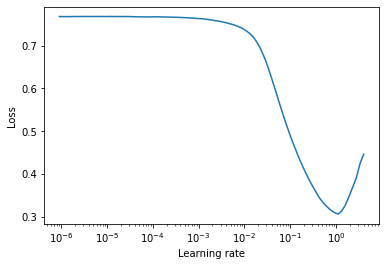

In [57]:
seed = 0
fold = 0 

seed_everything(seed)

train = process_data(folds)
test_ = process_data(test)

trn_idx = train[train['kfold'] != fold].index
val_idx = train[train['kfold'] == fold].index

train_df = train[train['kfold'] != fold].reset_index(drop=True)
valid_df = train[train['kfold'] == fold].reset_index(drop=True)

x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values

class MoADataset_:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return (dct['x'], dct['y'])#dct

train_dataset = MoADataset_(x_train, y_train)
valid_dataset = MoADataset_(x_valid, y_valid)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = Model(
    num_features=num_features,
    num_targets=num_targets,
    hidden_size=hidden_size,
)

#model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=WEIGHT_DECAY)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
#                                           max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))

criterion = nn.BCEWithLogitsLoss()

from torch_lr_finder import LRFinder

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [58]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [59]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [60]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3 ,4, 5]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

FOLD: 0, EPOCH: 0, train_loss: 0.6361924636623134
FOLD: 0, EPOCH: 0, valid_loss: 0.12679658085107803
FOLD: 0, EPOCH: 1, train_loss: 0.03631133617212375
FOLD: 0, EPOCH: 1, valid_loss: 0.02126673837857587
FOLD: 0, EPOCH: 2, train_loss: 0.021404008597027565
FOLD: 0, EPOCH: 2, valid_loss: 0.018931861647537778
FOLD: 0, EPOCH: 3, train_loss: 0.019319192803316357
FOLD: 0, EPOCH: 3, valid_loss: 0.017945447404469763
FOLD: 0, EPOCH: 4, train_loss: 0.01848986051787717
FOLD: 0, EPOCH: 4, valid_loss: 0.01765371627573456
FOLD: 0, EPOCH: 5, train_loss: 0.01812400357743752
FOLD: 0, EPOCH: 5, valid_loss: 0.01741944681853056
FOLD: 0, EPOCH: 6, train_loss: 0.017864147288913744
FOLD: 0, EPOCH: 6, valid_loss: 0.01736761767949377
FOLD: 0, EPOCH: 7, train_loss: 0.017680573749585426
FOLD: 0, EPOCH: 7, valid_loss: 0.01741527672857046
FOLD: 0, EPOCH: 8, train_loss: 0.017691371314551518
FOLD: 0, EPOCH: 8, valid_loss: 0.01727643563811268
FOLD: 0, EPOCH: 9, train_loss: 0.017627246623885803
FOLD: 0, EPOCH: 9, valid

FOLD: 2, EPOCH: 19, train_loss: 0.01726602841222632
FOLD: 2, EPOCH: 19, valid_loss: 0.016787780954369478
FOLD: 2, EPOCH: 20, train_loss: 0.017112264544635578
FOLD: 2, EPOCH: 20, valid_loss: 0.01673452133046729
FOLD: 2, EPOCH: 21, train_loss: 0.016931434465653223
FOLD: 2, EPOCH: 21, valid_loss: 0.016595536789723805
FOLD: 2, EPOCH: 22, train_loss: 0.016736421018730904
FOLD: 2, EPOCH: 22, valid_loss: 0.016465044527181557
FOLD: 2, EPOCH: 23, train_loss: 0.01656306407454869
FOLD: 2, EPOCH: 23, valid_loss: 0.016361435316503047
FOLD: 2, EPOCH: 24, train_loss: 0.016384119086939354
FOLD: 2, EPOCH: 24, valid_loss: 0.01628030264484031
FOLD: 2, EPOCH: 25, train_loss: 0.01617307774722576
FOLD: 2, EPOCH: 25, valid_loss: 0.016150407626160553
FOLD: 2, EPOCH: 26, train_loss: 0.016034217801053022
FOLD: 2, EPOCH: 26, valid_loss: 0.01608435921370983
FOLD: 2, EPOCH: 27, train_loss: 0.015805273067098165
FOLD: 2, EPOCH: 27, valid_loss: 0.016008143659148898
FOLD: 2, EPOCH: 28, train_loss: 0.015701762751500675

FOLD: 0, EPOCH: 8, train_loss: 0.017797908091080793
FOLD: 0, EPOCH: 8, valid_loss: 0.01748248740498509
FOLD: 0, EPOCH: 9, train_loss: 0.01776954544492174
FOLD: 0, EPOCH: 9, valid_loss: 0.017231564782559872
FOLD: 0, EPOCH: 10, train_loss: 0.01775025454201344
FOLD: 0, EPOCH: 10, valid_loss: 0.01720104943960905
FOLD: 0, EPOCH: 11, train_loss: 0.01772005899903783
FOLD: 0, EPOCH: 11, valid_loss: 0.017221748616014207
FOLD: 0, EPOCH: 12, train_loss: 0.017665545375126858
FOLD: 0, EPOCH: 12, valid_loss: 0.01729200003402574
FOLD: 0, EPOCH: 13, train_loss: 0.017648558598011732
FOLD: 0, EPOCH: 13, valid_loss: 0.01714056432247162
FOLD: 0, EPOCH: 14, train_loss: 0.0175016467810433
FOLD: 0, EPOCH: 14, valid_loss: 0.017387959440904006
FOLD: 0, EPOCH: 15, train_loss: 0.01746188753378996
FOLD: 0, EPOCH: 15, valid_loss: 0.01701790719692196
FOLD: 0, EPOCH: 16, train_loss: 0.017514628931826006
FOLD: 0, EPOCH: 16, valid_loss: 0.01697228726531778
FOLD: 0, EPOCH: 17, train_loss: 0.017399485142010708
FOLD: 0, 

FOLD: 2, EPOCH: 27, train_loss: 0.01575222390744349
FOLD: 2, EPOCH: 27, valid_loss: 0.01601972622530801
FOLD: 2, EPOCH: 28, train_loss: 0.015648807540697897
FOLD: 2, EPOCH: 28, valid_loss: 0.016045930316405638
FOLD: 2, EPOCH: 29, train_loss: 0.015577029308601133
FOLD: 2, EPOCH: 29, valid_loss: 0.016040150954255036
FOLD: 3, EPOCH: 0, train_loss: 0.6357311725184538
FOLD: 3, EPOCH: 0, valid_loss: 0.1334306320973805
FOLD: 3, EPOCH: 1, train_loss: 0.0364256819602156
FOLD: 3, EPOCH: 1, valid_loss: 0.021363991977913038
FOLD: 3, EPOCH: 2, train_loss: 0.02091571476742409
FOLD: 3, EPOCH: 2, valid_loss: 0.019744733135615075
FOLD: 3, EPOCH: 3, train_loss: 0.019254236090658367
FOLD: 3, EPOCH: 3, valid_loss: 0.018186297640204428
FOLD: 3, EPOCH: 4, train_loss: 0.01850948187833031
FOLD: 3, EPOCH: 4, valid_loss: 0.017856461767639432
FOLD: 3, EPOCH: 5, train_loss: 0.01808792163712391
FOLD: 3, EPOCH: 5, valid_loss: 0.01754667687096766
FOLD: 3, EPOCH: 6, train_loss: 0.01781815515183236
FOLD: 3, EPOCH: 6, 

FOLD: 0, EPOCH: 16, train_loss: 0.017406056155923052
FOLD: 0, EPOCH: 16, valid_loss: 0.016940288112631867
FOLD: 0, EPOCH: 17, train_loss: 0.017428269798772923
FOLD: 0, EPOCH: 17, valid_loss: 0.016983022327933993
FOLD: 0, EPOCH: 18, train_loss: 0.017354623225612053
FOLD: 0, EPOCH: 18, valid_loss: 0.01688423076910632
FOLD: 0, EPOCH: 19, train_loss: 0.017191048306615456
FOLD: 0, EPOCH: 19, valid_loss: 0.01682417406035321
FOLD: 0, EPOCH: 20, train_loss: 0.017103889822096065
FOLD: 0, EPOCH: 20, valid_loss: 0.016680089277880533
FOLD: 0, EPOCH: 21, train_loss: 0.016981349974546745
FOLD: 0, EPOCH: 21, valid_loss: 0.016630347818136215
FOLD: 0, EPOCH: 22, train_loss: 0.016723293034980696
FOLD: 0, EPOCH: 22, valid_loss: 0.016507816713835513
FOLD: 0, EPOCH: 23, train_loss: 0.01656119391133172
FOLD: 0, EPOCH: 23, valid_loss: 0.01637924797832966
FOLD: 0, EPOCH: 24, train_loss: 0.01641524795010902
FOLD: 0, EPOCH: 24, valid_loss: 0.0162867024274809
FOLD: 0, EPOCH: 25, train_loss: 0.016152501997092495


FOLD: 3, EPOCH: 5, train_loss: 0.018292571451730917
FOLD: 3, EPOCH: 5, valid_loss: 0.017729481203215464
FOLD: 3, EPOCH: 6, train_loss: 0.017903340568739004
FOLD: 3, EPOCH: 6, valid_loss: 0.017528375850192138
FOLD: 3, EPOCH: 7, train_loss: 0.017796800168150145
FOLD: 3, EPOCH: 7, valid_loss: 0.017513979519052165
FOLD: 3, EPOCH: 8, train_loss: 0.01765408325076535
FOLD: 3, EPOCH: 8, valid_loss: 0.017331282634820255
FOLD: 3, EPOCH: 9, train_loss: 0.017581056101598602
FOLD: 3, EPOCH: 9, valid_loss: 0.017299326642283373
FOLD: 3, EPOCH: 10, train_loss: 0.017661271542580664
FOLD: 3, EPOCH: 10, valid_loss: 0.017290898439075265
FOLD: 3, EPOCH: 11, train_loss: 0.01758090244687122
FOLD: 3, EPOCH: 11, valid_loss: 0.01726261270897729
FOLD: 3, EPOCH: 12, train_loss: 0.01758909582470854
FOLD: 3, EPOCH: 12, valid_loss: 0.017260216043463776
FOLD: 3, EPOCH: 13, train_loss: 0.0174499138366377
FOLD: 3, EPOCH: 13, valid_loss: 0.017265091437314237
FOLD: 3, EPOCH: 14, train_loss: 0.017467839440897755
FOLD: 3, 

FOLD: 0, EPOCH: 24, train_loss: 0.0162845093594945
FOLD: 0, EPOCH: 24, valid_loss: 0.016312060318887232
FOLD: 0, EPOCH: 25, train_loss: 0.016067105709858562
FOLD: 0, EPOCH: 25, valid_loss: 0.016173003134982926
FOLD: 0, EPOCH: 26, train_loss: 0.01585450867001993
FOLD: 0, EPOCH: 26, valid_loss: 0.016104704939893313
FOLD: 0, EPOCH: 27, train_loss: 0.01567392460866899
FOLD: 0, EPOCH: 27, valid_loss: 0.016083914626921925
FOLD: 0, EPOCH: 28, train_loss: 0.015591973931515131
FOLD: 0, EPOCH: 28, valid_loss: 0.01604442237211125
FOLD: 0, EPOCH: 29, train_loss: 0.015477115862017525
FOLD: 0, EPOCH: 29, valid_loss: 0.016055358148046903
FOLD: 1, EPOCH: 0, train_loss: 0.6342874024657236
FOLD: 1, EPOCH: 0, valid_loss: 0.12918611594608853
FOLD: 1, EPOCH: 1, train_loss: 0.035637856987507446
FOLD: 1, EPOCH: 1, valid_loss: 0.02094732102538858
FOLD: 1, EPOCH: 2, train_loss: 0.021171640969164993
FOLD: 1, EPOCH: 2, valid_loss: 0.019071066113454955
FOLD: 1, EPOCH: 3, train_loss: 0.019390746222242065
FOLD: 1, 

FOLD: 3, EPOCH: 13, train_loss: 0.017466556449569223
FOLD: 3, EPOCH: 13, valid_loss: 0.017433598744017738
FOLD: 3, EPOCH: 14, train_loss: 0.017430314652459776
FOLD: 3, EPOCH: 14, valid_loss: 0.017155653557607106
FOLD: 3, EPOCH: 15, train_loss: 0.017394927600263687
FOLD: 3, EPOCH: 15, valid_loss: 0.017228461376258306
FOLD: 3, EPOCH: 16, train_loss: 0.017315842292231064
FOLD: 3, EPOCH: 16, valid_loss: 0.017210461172674385
FOLD: 3, EPOCH: 17, train_loss: 0.017283777902037768
FOLD: 3, EPOCH: 17, valid_loss: 0.017101695628038475
FOLD: 3, EPOCH: 18, train_loss: 0.017146753477931456
FOLD: 3, EPOCH: 18, valid_loss: 0.016889447239892823
FOLD: 3, EPOCH: 19, train_loss: 0.017092089033753113
FOLD: 3, EPOCH: 19, valid_loss: 0.016877833913479533
FOLD: 3, EPOCH: 20, train_loss: 0.016898686538679875
FOLD: 3, EPOCH: 20, valid_loss: 0.01677028103066342
FOLD: 3, EPOCH: 21, train_loss: 0.016785534861349108
FOLD: 3, EPOCH: 21, valid_loss: 0.0166994929845844
FOLD: 3, EPOCH: 22, train_loss: 0.016667546481703

FOLD: 1, EPOCH: 2, train_loss: 0.020949773598408352
FOLD: 1, EPOCH: 2, valid_loss: 0.019174949771591596
FOLD: 1, EPOCH: 3, train_loss: 0.01926739365402339
FOLD: 1, EPOCH: 3, valid_loss: 0.017980888459299293
FOLD: 1, EPOCH: 4, train_loss: 0.018507435506182737
FOLD: 1, EPOCH: 4, valid_loss: 0.017598469581987176
FOLD: 1, EPOCH: 5, train_loss: 0.01813141872053561
FOLD: 1, EPOCH: 5, valid_loss: 0.01730435522539275
FOLD: 1, EPOCH: 6, train_loss: 0.017817217613691868
FOLD: 1, EPOCH: 6, valid_loss: 0.017266615347138473
FOLD: 1, EPOCH: 7, train_loss: 0.01770446028398431
FOLD: 1, EPOCH: 7, valid_loss: 0.017207510503275052
FOLD: 1, EPOCH: 8, train_loss: 0.017712817918779194
FOLD: 1, EPOCH: 8, valid_loss: 0.01717364444796528
FOLD: 1, EPOCH: 9, train_loss: 0.017688479173280622
FOLD: 1, EPOCH: 9, valid_loss: 0.017128608588661467
FOLD: 1, EPOCH: 10, train_loss: 0.017637351433328098
FOLD: 1, EPOCH: 10, valid_loss: 0.01731229153062616
FOLD: 1, EPOCH: 11, train_loss: 0.01765897256605651
FOLD: 1, EPOCH: 

FOLD: 3, EPOCH: 21, train_loss: 0.016889443688526535
FOLD: 3, EPOCH: 21, valid_loss: 0.01674791473363127
FOLD: 3, EPOCH: 22, train_loss: 0.016656596125845892
FOLD: 3, EPOCH: 22, valid_loss: 0.01666387197162424
FOLD: 3, EPOCH: 23, train_loss: 0.016566451983121427
FOLD: 3, EPOCH: 23, valid_loss: 0.016547099021928652
FOLD: 3, EPOCH: 24, train_loss: 0.016273073825067368
FOLD: 3, EPOCH: 24, valid_loss: 0.01649050997304065
FOLD: 3, EPOCH: 25, train_loss: 0.016104784078788067
FOLD: 3, EPOCH: 25, valid_loss: 0.01639770343899727
FOLD: 3, EPOCH: 26, train_loss: 0.015916168446774067
FOLD: 3, EPOCH: 26, valid_loss: 0.016282433776983192
FOLD: 3, EPOCH: 27, train_loss: 0.015689484255415373
FOLD: 3, EPOCH: 27, valid_loss: 0.016270361760897297
FOLD: 3, EPOCH: 28, train_loss: 0.015539467577701029
FOLD: 3, EPOCH: 28, valid_loss: 0.016258587475333895
FOLD: 3, EPOCH: 29, train_loss: 0.015543135247476723
FOLD: 3, EPOCH: 29, valid_loss: 0.016257583004023347
FOLD: 4, EPOCH: 0, train_loss: 0.6346330474252286


FOLD: 1, EPOCH: 10, train_loss: 0.01768444793001897
FOLD: 1, EPOCH: 10, valid_loss: 0.017281777544745375
FOLD: 1, EPOCH: 11, train_loss: 0.01755310549819167
FOLD: 1, EPOCH: 11, valid_loss: 0.017197187058627605
FOLD: 1, EPOCH: 12, train_loss: 0.01759840687736869
FOLD: 1, EPOCH: 12, valid_loss: 0.017150296111192023
FOLD: 1, EPOCH: 13, train_loss: 0.01751112242134801
FOLD: 1, EPOCH: 13, valid_loss: 0.017071143963507243
FOLD: 1, EPOCH: 14, train_loss: 0.017597287427634
FOLD: 1, EPOCH: 14, valid_loss: 0.017100203755710808
FOLD: 1, EPOCH: 15, train_loss: 0.017443882051747347
FOLD: 1, EPOCH: 15, valid_loss: 0.01698110470814364
FOLD: 1, EPOCH: 16, train_loss: 0.017402473600932222
FOLD: 1, EPOCH: 16, valid_loss: 0.01689200151179518
FOLD: 1, EPOCH: 17, train_loss: 0.017340509781101042
FOLD: 1, EPOCH: 17, valid_loss: 0.016971249133348465
FOLD: 1, EPOCH: 18, train_loss: 0.017174295520922846
FOLD: 1, EPOCH: 18, valid_loss: 0.016999512910842896
FOLD: 1, EPOCH: 19, train_loss: 0.01711268984861132
FOL

FOLD: 3, EPOCH: 29, train_loss: 0.01553491004270272
FOLD: 3, EPOCH: 29, valid_loss: 0.016246318630874158
FOLD: 4, EPOCH: 0, train_loss: 0.6361787112942641
FOLD: 4, EPOCH: 0, valid_loss: 0.1262929245829582
FOLD: 4, EPOCH: 1, train_loss: 0.03589353603783293
FOLD: 4, EPOCH: 1, valid_loss: 0.021437718027404375
FOLD: 4, EPOCH: 2, train_loss: 0.020885232741526073
FOLD: 4, EPOCH: 2, valid_loss: 0.018992896085338933
FOLD: 4, EPOCH: 3, train_loss: 0.019224420776995627
FOLD: 4, EPOCH: 3, valid_loss: 0.01800377539225987
FOLD: 4, EPOCH: 4, train_loss: 0.018493638481890808
FOLD: 4, EPOCH: 4, valid_loss: 0.01752533795578139
FOLD: 4, EPOCH: 5, train_loss: 0.018110463220248188
FOLD: 4, EPOCH: 5, valid_loss: 0.01735641559852021
FOLD: 4, EPOCH: 6, train_loss: 0.017751416366925274
FOLD: 4, EPOCH: 6, valid_loss: 0.017279315127858092
FOLD: 4, EPOCH: 7, train_loss: 0.017711965846356707
FOLD: 4, EPOCH: 7, valid_loss: 0.017475849682731286
FOLD: 4, EPOCH: 8, train_loss: 0.01780970487743616
FOLD: 4, EPOCH: 8, v

In [61]:
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
len(target_cols)

206

In [63]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)

CV log_loss:  0.014740091182323401


In [64]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)